In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
#https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd

### Linear Regression via TF2

Epoch  0: W=4.98 b=0.02, loss=9.49711
Epoch 10: W=4.78 b=0.22, loss=7.88492
Epoch 20: W=4.58 b=0.42, loss=6.44280
Epoch 30: W=4.38 b=0.62, loss=5.17076
Epoch 40: W=4.18 b=0.82, loss=4.06880
Epoch 50: W=3.98 b=1.02, loss=3.13691
Epoch 60: W=3.78 b=1.22, loss=2.37510
Epoch 70: W=3.58 b=1.42, loss=1.78337
Epoch 80: W=3.38 b=1.62, loss=1.36172
Epoch 90: W=3.18 b=1.82, loss=1.11014
Epoch 100: W=2.98 b=1.98, loss=1.02856
Epoch 110: W=2.98 b=1.98, loss=1.02856
Epoch 120: W=2.98 b=1.98, loss=1.02856
Epoch 130: W=2.98 b=1.98, loss=1.02856
Epoch 140: W=2.98 b=1.98, loss=1.02856
Epoch 150: W=2.98 b=1.98, loss=1.02856
Epoch 160: W=2.98 b=1.98, loss=1.02856
Epoch 170: W=2.98 b=1.98, loss=1.02856


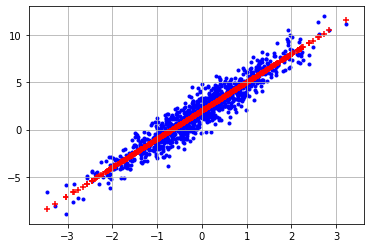

tf.Tensor(6.9169307, shape=(), dtype=float32)  vs.  6.9569


In [2]:
class Model(object):
    def __init__(self):
        # Initialize the weights to `5.0` and the bias to `0.0`
        # In practice, these should be initialized to random values (for example, with `tf.random.normal`)
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)

    def __call__(self, x):
        return self.W * x + self.b

def loss(target_y, predicted_y):
    return tf.reduce_mean(tf.square(target_y - predicted_y))
    
def trainStep(model, optimizer, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(outputs, model(inputs))
    dW, db = t.gradient(current_loss, [model.W, model.b])
    optimizer.apply_gradients( zip( [dW,db] , [model.W, model.b] ) )
    
def trainModel(model,inputs,outputs):
    optimizer = tf.optimizers.Adam( learning_rate=LEARNING_RATE, beta_1 = 0.00, beta_2 = 0.00 )
    for epoch in range(EPOCHS):
        current_loss = loss(outputs, model(inputs))
        trainStep(model, optimizer, inputs, outputs, learning_rate=LEARNING_RATE)
        if epoch%10==0:
            print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' % (epoch, model.W.numpy(), model.b.numpy(), current_loss))
            
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000
LEARNING_RATE = 0.02
EPOCHS = 180

tf.random.set_seed(1)
inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

model = Model()
trainModel(model,inputs,outputs)

plt.scatter(inputs, outputs, c='b',marker='.')
plt.scatter(inputs, model(inputs), c='r',marker='+')
plt.grid(True)
plt.show()

#Prediction
x=1.6523
print(model(x),' vs. ',TRUE_W*x+TRUE_b)

### MNIST recognizer - Load Data

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

dfTrain = pd.read_csv('train.csv')
dfTest  = pd.read_csv('test.csv')

X     = dfTrain[dfTrain.columns[1:]].to_numpy()
y     = dfTrain[dfTrain.columns[0]].to_numpy()

train_X, valid_X, train_y, valid_y = train_test_split(X,y,shuffle=False, random_state=1)
test_X = dfTest.to_numpy()

print(train_X.shape,valid_X.shape)

(31500, 784) (10500, 784)


### Standard code around the model

In [24]:
def loss(target_y, predicted_y):
    return tf.losses.categorical_crossentropy(target_y, predicted_y)

def trainModel(model, inputs, outputs, inputs2, outputs2):
    
    cross_entTrain = []
    accTrain = []
    cross_entTest = []
    accTest = []

    optimizer = tf.optimizers.Adam( learning_rate = LEARNING_RATE, beta_1 = BETA_1, beta_2 = BETA_2 )
    
    nbrOfBatches = len(inputs)//BATCH_SIZE
    inputBatches  = np.array_split(inputs, nbrOfBatches)
    outputBatches = np.array_split(outputs,nbrOfBatches)
    print('number of batches: ',nbrOfBatches)
    
    for epoch in range(EPOCHS):
        for batch in range(nbrOfBatches):
            images = inputBatches[batch]
            labels = outputBatches[batch]
            current_loss = trainStep(model, optimizer, images, labels)
            
            cross_entropy = -tf.reduce_sum(labels * tf.math.log(model(images))).numpy()
            is_correct = tf.equal(tf.argmax(labels,1),tf.argmax(model(images),1))
            accuracy = tf.reduce_mean(tf.cast(is_correct,tf.float32)).numpy()
            cross_entTrain.append(cross_entropy)
            accTrain.append(accuracy)
            
            cross_entropy2 = -tf.reduce_sum(outputs2 * tf.math.log(model(inputs2))).numpy()/len(outputs2)*BATCH_SIZE
            is_correct2 = tf.equal(tf.argmax(outputs2,1),tf.argmax(model(inputs2),1))
            accuracy2 = tf.reduce_mean(tf.cast(is_correct2,tf.float32)).numpy()
            cross_entTest.append(cross_entropy2)
            accTest.append(accuracy2)
            
        if epoch%1==0:
            print(epoch, cross_entropy,accuracy)
            
    return cross_entTrain, accTrain, cross_entTest, accTest

def predictModel(test_X, n):
    X = [test_X[n]]
    X = tf.cast(X, dtype=tf.float32)
    pred = np.round(model(X),2)
    print(pred, '  ->   ', np.argmax(pred))
    plt.imshow(test_X[n].reshape(28,28))

### MNIST simple 1 layer

In [64]:
class Model(object):
    def __init__(self):
        #initializer = tf.initializers.glorot_uniform()
        initializer = tf.random_normal_initializer(mean=0.0, stddev=0.1, seed=42)
        self.W = tf.Variable(initializer([784,10]), name='W', trainable=True, dtype=tf.float32)
        self.b = tf.Variable(initializer([10]),     name='b', trainable=True, dtype=tf.float32)

    def __call__(self, X):
        X = tf.cast(X/255, dtype=tf.float32)
        return tf.nn.softmax( tf.matmul(X,self.W) + self.b)

def trainStep(model, optimizer, inputs, outputs):
    with tf.GradientTape() as t:
        current_loss = loss(outputs, model(inputs))
    dW, db = t.gradient(current_loss, [model.W, model.b])
    optimizer.apply_gradients( zip( [dW,db] , [model.W, model.b] ) )
    return current_loss
    
LEARNING_RATE = 0.003
BETA_1 = 0.05 #0.9
BETA_2 = 0.05 #0.999
EPOCHS = 4
BATCH_SIZE = 100

model = Model()
cross_entTrain, accTrain, cross_entTest, accTest = trainModel(model, train_X,  tf.one_hot(train_y,depth=10), valid_X, tf.one_hot(valid_y,depth=10)  )
cross_entTrainA, accTrainA, cross_entTestA, accTestA = cross_entTrain, accTrain, cross_entTest, accTest

number of batches:  315
0 27.591774 0.91
1 25.458183 0.93
2 25.31348 0.95
3 nan 0.95


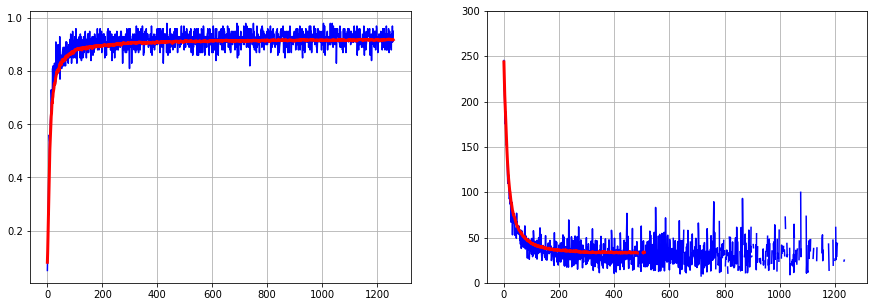

In [65]:
f, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(accTrain, 'b-')
ax[0].plot(accTest, 'r-',linewidth=3.0)
ax[0].grid(True)
ax[1].plot(cross_entTrain, 'b-')
ax[1].plot(cross_entTest, 'r-',linewidth=3.0)
ax[1].set_ylim(0,300)
ax[1].grid(True)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]   ->    0


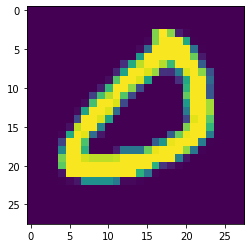

In [43]:
# use model to predict
predictModel(test_X, 3893)

### MNIST 5 non-clonvolutional layer model (with K=200, L=100, M=60, N=30, 10 nodes)

In [66]:
class Model(object):
    def __init__(self):
        
        K = 200
        L = 100
        M =  60
        N =  30
        
        initializer = tf.random_normal_initializer(mean=0.0, stddev=0.1, seed=42)
        self.W1 = tf.Variable(initializer([784,K]), name='W1', trainable=True, dtype=tf.float32)
        self.b1 = tf.Variable(initializer([K]),     name='b1', trainable=True, dtype=tf.float32)
        
        self.W2 = tf.Variable(initializer([K,L]), name='W2', trainable=True, dtype=tf.float32)
        self.b2 = tf.Variable(initializer([L]),   name='b2', trainable=True, dtype=tf.float32)

        self.W3 = tf.Variable(initializer([L,M]), name='W3', trainable=True, dtype=tf.float32)
        self.b3 = tf.Variable(initializer([M]),   name='b3', trainable=True, dtype=tf.float32)

        self.W4 = tf.Variable(initializer([M,N]), name='W4', trainable=True, dtype=tf.float32)
        self.b4 = tf.Variable(initializer([N]),   name='b4', trainable=True, dtype=tf.float32)

        self.W5 = tf.Variable(initializer([N,10]), name='W5', trainable=True, dtype=tf.float32)
        self.b5 = tf.Variable(initializer([10]),   name='b5', trainable=True, dtype=tf.float32)
        
    def __call__(self, X):

        X  = tf.cast(X/255, dtype=tf.float32)
        Y1 = tf.nn.sigmoid( tf.matmul(X,self.W1) + self.b1)
        Y2 = tf.nn.sigmoid( tf.matmul(Y1,self.W2) + self.b2)
        Y3 = tf.nn.sigmoid( tf.matmul(Y2,self.W3) + self.b3)
        Y4 = tf.nn.sigmoid( tf.matmul(Y3,self.W4) + self.b4)
        return tf.nn.softmax( tf.matmul(Y4,self.W5) + self.b5)

def trainStep(model, optimizer, inputs, outputs):
    with tf.GradientTape() as t:
        current_loss = loss(outputs, model(inputs))
    dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5 = t.gradient(current_loss, [model.W1, model.b1, model.W2, model.b2,model.W3, model.b3,model.W4, model.b4,model.W5, model.b5])
    optimizer.apply_gradients( zip( [dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5] , [model.W1, model.b1, model.W2, model.b2,model.W3, model.b3,model.W4, model.b4,model.W5, model.b5] ) )
    return current_loss
    
LEARNING_RATE = 0.003
BETA_1 = 0.005  #0.9
BETA_2 = 0.005  #0.999
EPOCHS = 4
BATCH_SIZE = 100

model = Model()
cross_entTrain, accTrain, cross_entTest, accTest = trainModel(model, train_X,  tf.one_hot(train_y,depth=10), valid_X, tf.one_hot(valid_y,depth=10)  )
cross_entTrainB, accTrainB, cross_entTestB, accTestB = cross_entTrain, accTrain, cross_entTest, accTest


number of batches:  315
0 57.379402 0.85
1 26.68933 0.94
2 16.980766 0.96
3 15.326736 0.96


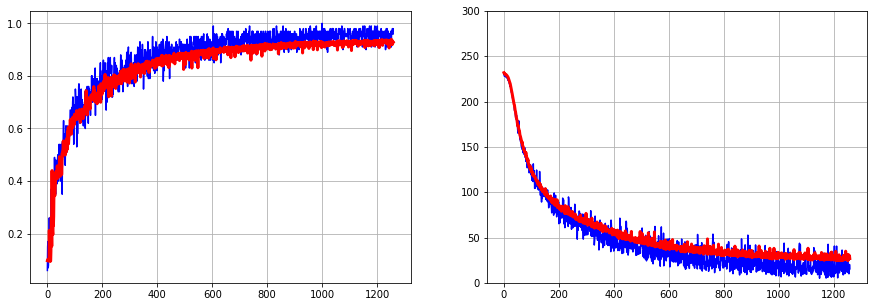

In [67]:
f, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(accTrain, 'b-')
ax[0].plot(accTest, 'r-',linewidth=3.0)
ax[0].grid(True)
ax[1].plot(cross_entTrain, 'b-')
ax[1].plot(cross_entTest, 'r-',linewidth=3.0)
ax[1].set_ylim(0,300)
ax[1].grid(True)

### sigmoid to relu

In [69]:
class Model(object):
    def __init__(self):
        
        K = 200
        L = 100
        M =  60
        N =  30
        
        initializer = tf.random_normal_initializer(mean=0.0, stddev=0.1, seed=42)
        self.W1 = tf.Variable(initializer([784,K]), name='W1', trainable=True, dtype=tf.float32)
        self.b1 = tf.Variable(initializer([K]),     name='b1', trainable=True, dtype=tf.float32)
        
        self.W2 = tf.Variable(initializer([K,L]), name='W2', trainable=True, dtype=tf.float32)
        self.b2 = tf.Variable(initializer([L]),   name='b2', trainable=True, dtype=tf.float32)

        self.W3 = tf.Variable(initializer([L,M]), name='W3', trainable=True, dtype=tf.float32)
        self.b3 = tf.Variable(initializer([M]),   name='b3', trainable=True, dtype=tf.float32)

        self.W4 = tf.Variable(initializer([M,N]), name='W4', trainable=True, dtype=tf.float32)
        self.b4 = tf.Variable(initializer([N]),   name='b4', trainable=True, dtype=tf.float32)

        self.W5 = tf.Variable(initializer([N,10]), name='W5', trainable=True, dtype=tf.float32)
        self.b5 = tf.Variable(initializer([10]),   name='b5', trainable=True, dtype=tf.float32)
        
    def __call__(self, X):

        X  = tf.cast(X/255, dtype=tf.float32)
        Y1 = tf.nn.relu( tf.matmul(X,self.W1) + self.b1)
        Y2 = tf.nn.relu( tf.matmul(Y1,self.W2) + self.b2)
        Y3 = tf.nn.relu( tf.matmul(Y2,self.W3) + self.b3)
        Y4 = tf.nn.relu( tf.matmul(Y3,self.W4) + self.b4)
        return tf.nn.softmax( tf.matmul(Y4,self.W5) + self.b5)

def trainStep(model, optimizer, inputs, outputs):
    with tf.GradientTape() as t:
        current_loss = loss(outputs, model(inputs))
    dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5 = t.gradient(current_loss, [model.W1, model.b1, model.W2, model.b2,model.W3, model.b3,model.W4, model.b4,model.W5, model.b5])
    optimizer.apply_gradients( zip( [dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5] , [model.W1, model.b1, model.W2, model.b2,model.W3, model.b3,model.W4, model.b4,model.W5, model.b5] ) )
    return current_loss
    
LEARNING_RATE = 0.003
BETA_1 = 0.005  #0.9
BETA_2 = 0.005  #0.999
EPOCHS = 4
BATCH_SIZE = 100

model = Model()
cross_entTrain, accTrain, cross_entTest, accTest = trainModel(model, train_X,  tf.one_hot(train_y,depth=10), valid_X, tf.one_hot(valid_y,depth=10)  )
cross_entTrainC, accTrainC, cross_entTestC, accTestC = cross_entTrain, accTrain, cross_entTest, accTest



number of batches:  315
0 7.2316046 0.99
1 nan 0.97
2 nan 0.94
3 nan 0.99


### Adam learning rate decay

In [203]:
class Model(object):
    def __init__(self):
        
        K = 200
        L = 100
        M =  60
        N =  30
        
        initializer = tf.random_normal_initializer(mean=0.0, stddev=0.1, seed=42)
        self.W1 = tf.Variable(initializer([784,K]), name='W1', trainable=True, dtype=tf.float32)
        self.b1 = tf.Variable(initializer([K]),     name='b1', trainable=True, dtype=tf.float32)
        
        self.W2 = tf.Variable(initializer([K,L]), name='W2', trainable=True, dtype=tf.float32)
        self.b2 = tf.Variable(initializer([L]),   name='b2', trainable=True, dtype=tf.float32)

        self.W3 = tf.Variable(initializer([L,M]), name='W3', trainable=True, dtype=tf.float32)
        self.b3 = tf.Variable(initializer([M]),   name='b3', trainable=True, dtype=tf.float32)

        self.W4 = tf.Variable(initializer([M,N]), name='W4', trainable=True, dtype=tf.float32)
        self.b4 = tf.Variable(initializer([N]),   name='b4', trainable=True, dtype=tf.float32)

        self.W5 = tf.Variable(initializer([N,10]), name='W5', trainable=True, dtype=tf.float32)
        self.b5 = tf.Variable(initializer([10]),   name='b5', trainable=True, dtype=tf.float32)
        
    def __call__(self, X):

        X  = tf.cast(X/255, dtype=tf.float32)
        Y1 = tf.nn.relu( tf.matmul(X,self.W1) + self.b1)
        Y2 = tf.nn.relu( tf.matmul(Y1,self.W2) + self.b2)
        Y3 = tf.nn.relu( tf.matmul(Y2,self.W3) + self.b3)
        Y4 = tf.nn.relu( tf.matmul(Y3,self.W4) + self.b4)
        return tf.nn.softmax( tf.matmul(Y4,self.W5) + self.b5)

def trainStep(model, optimizer, inputs, outputs):
    with tf.GradientTape() as t:
        current_loss = loss(outputs, model(inputs))
    dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5 = t.gradient(current_loss, [model.W1, model.b1, model.W2, model.b2,model.W3, model.b3,model.W4, model.b4,model.W5, model.b5])
    optimizer.apply_gradients( zip( [dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5] , [model.W1, model.b1, model.W2, model.b2,model.W3, model.b3,model.W4, model.b4,model.W5, model.b5] ) )
    return current_loss
    
LEARNING_RATE = 0.003
BETA_1 = 0.9
BETA_2 = 0.999
EPOCHS = 20
BATCH_SIZE = 100

model = Model()
cross_entTrain, accTrain, cross_entTest, accTest = trainModel(model, train_X,  tf.one_hot(train_y,depth=10), valid_X, tf.one_hot(valid_y,depth=10)  )
cross_entTrainD, accTrainD, cross_entTestD, accTestD = cross_entTrain, accTrain, cross_entTest, accTest

number of batches:  315
0 12.73505 0.95
1 6.3720675 0.97
2 3.2786946 0.99
3 0.8851926 1.0
4 1.069355 1.0
5 1.9334106 0.99
6 2.0496278 1.0
7 1.6879189 0.99
8 0.5206413 1.0
9 1.0116374 1.0
10 0.47444284 1.0
11 0.44290462 1.0
12 1.6973926 0.99
13 0.17797838 1.0
14 2.2425978 0.99
15 0.44301498 1.0
16 0.5673976 1.0
17 3.011293 0.99
18 0.2685722 1.0
19 0.09993081 1.0


In [ ]:
class Model(object):
    def __init__(self):
        
        K = 200
        L = 100
        M =  60
        N =  30
        
        initializer = tf.random_normal_initializer(mean=0.0, stddev=0.1, seed=42)
        self.W1 = tf.Variable(initializer([784,K]), name='W1', trainable=True, dtype=tf.float32)
        self.b1 = tf.Variable(initializer([K]),     name='b1', trainable=True, dtype=tf.float32)
        
        self.W2 = tf.Variable(initializer([K,L]), name='W2', trainable=True, dtype=tf.float32)
        self.b2 = tf.Variable(initializer([L]),   name='b2', trainable=True, dtype=tf.float32)

        self.W3 = tf.Variable(initializer([L,M]), name='W3', trainable=True, dtype=tf.float32)
        self.b3 = tf.Variable(initializer([M]),   name='b3', trainable=True, dtype=tf.float32)

        self.W4 = tf.Variable(initializer([M,N]), name='W4', trainable=True, dtype=tf.float32)
        self.b4 = tf.Variable(initializer([N]),   name='b4', trainable=True, dtype=tf.float32)

        self.W5 = tf.Variable(initializer([N,10]), name='W5', trainable=True, dtype=tf.float32)
        self.b5 = tf.Variable(initializer([10]),   name='b5', trainable=True, dtype=tf.float32)
        
    def __call__(self, X):

        X  = tf.cast(X/255, dtype=tf.float32)
        Y1 = tf.nn.relu( tf.matmul(X,self.W1) + self.b1)
        Y1d= tf.nn.dropout(Y1,PKEEP)
        Y2 = tf.nn.relu( tf.matmul(Y1d,self.W2) + self.b2)
        Y2d= tf.nn.dropout(Y2,PKEEP)
        Y3 = tf.nn.relu( tf.matmul(Y2d,self.W3) + self.b3)
        Y3d= tf.nn.dropout(Y3,PKEEP)
        Y4 = tf.nn.relu( tf.matmul(Y3d,self.W4) + self.b4)
        Y4d= tf.nn.dropout(Y4,PKEEP)
        return tf.nn.softmax( tf.matmul(Y4d,self.W5) + self.b5)

def trainStep(model, optimizer, inputs, outputs):
    with tf.GradientTape() as t:
        current_loss = loss(outputs, model(inputs))
    dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5 = t.gradient(current_loss, [model.W1, model.b1, model.W2, model.b2,model.W3, model.b3,model.W4, model.b4,model.W5, model.b5])
    optimizer.apply_gradients( zip( [dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5] , [model.W1, model.b1, model.W2, model.b2,model.W3, model.b3,model.W4, model.b4,model.W5, model.b5] ) )
    return current_loss
    
LEARNING_RATE = 0.003
BETA_1 = 0.9
BETA_2 = 0.999
EPOCHS = 20
BATCH_SIZE = 100
PKEEP = # different Values for 

model = Model()
cross_entTrain, accTrain, cross_entTest, accTest = trainModel(model, train_X,  tf.one_hot(train_y,depth=10), valid_X, tf.one_hot(valid_y,depth=10)  )
cross_entTrainE, accTrainE, cross_entTestE, accTestE = cross_entTrain, accTrain, cross_entTest, accTest

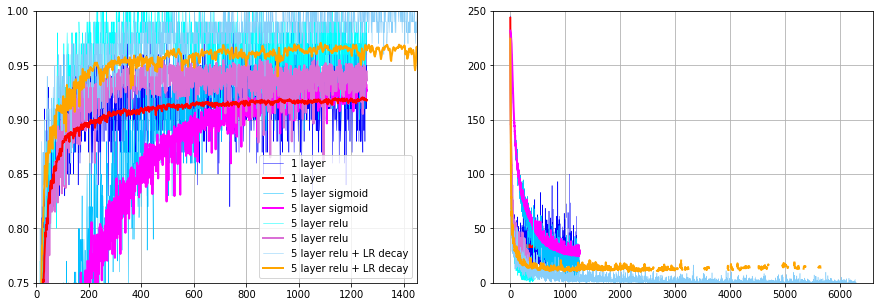

In [210]:
f, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(accTrainA, color='blue',linewidth=0.5,label='1 layer')
ax[0].plot(accTestA, color='red',linewidth=2.0,label='1 layer')
ax[0].plot(accTrainB, color='deepskyblue',linewidth=0.5,label='5 layer sigmoid')
ax[0].plot(accTestB, color='magenta',linewidth=2.0,label='5 layer sigmoid')
ax[0].plot(accTrainC, color='cyan',linewidth=0.5,label='5 layer relu')
ax[0].plot(accTestC, color='orchid',linewidth=2.0,label='5 layer relu')

ax[0].plot(accTrainD, color='lightskyblue',linewidth=0.5,label='5 layer relu + LR decay')
ax[0].plot(accTestD, color='orange',linewidth=2.0,label='5 layer relu + LR decay')

ax[0].plot(accTestA, color='red',linewidth=2.0)

ax[0].legend()
ax[0].set_xlim(0,1450)
ax[0].set_ylim(0.75,1.0)
ax[0].grid(True)

ax[1].plot(cross_entTrainA, color='blue',linewidth=0.5)
ax[1].plot(cross_entTestA, color='red',linewidth=2.0)
ax[1].plot(cross_entTrainB, color='deepskyblue',linewidth=0.5)
ax[1].plot(cross_entTestB, color='magenta',linewidth=2.0)
ax[1].plot(cross_entTrainC, color='cyan',linewidth=0.5)
ax[1].plot(cross_entTestC, color='orchid',linewidth=2.0)
ax[1].plot(cross_entTrainD, color='lightskyblue',linewidth=0.5)
ax[1].plot(cross_entTestD, color='orange',linewidth=2.0)


ax[1].set_ylim(0,250)
ax[1].grid(True)